In [1]:
from bias_multi_utils import *
from collections import Counter

In [2]:
results_dir = "results_multi"

model_strs = ['meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-13b-chat-hf', \
			  'meta-llama/Meta-Llama-3-8B-Instruct', 'meta-llama/Llama-3.1-8B-Instruct',\
			  'google/gemma-2b-it', 'google/gemma-7b-it', \
				'Qwen/Qwen-7B-Chat', 'Qwen/Qwen-14B-Chat',\
				'Qwen/Qwen2.5-7B-Instruct', 'Qwen/Qwen2.5-14B-Instruct', 'deepseek-ai/deepseek-llm-7b-chat']

# Calculate ASR, DPD, KL-divergence, and runtime for each model, and category

In [3]:
model2_mean_results = {}
query_variations = 10

for model_str in tqdm.tqdm(model_strs):
	model_name = os.path.basename(model_str)
	print(f"Processing model: {model_name}")

	results_directory = os.path.join(results_dir, model_name)

	direction_gen_time_file = os.path.join(results_directory, "direction_gen_time.csv")
	direction_gen_time_df = pd.read_csv(direction_gen_time_file)

	total_runtime = direction_gen_time_df['time_taken'].sum()

	quiz_results_directory = os.path.join(results_directory, "quiz_bias")

	bias_results_dict = {}
	# loop over directories in quiz_results_directory
	for direction_dir in tqdm.tqdm(os.listdir(quiz_results_directory)):
		real_results_dir = os.path.join(quiz_results_directory, direction_dir)
		direction_results_dict = get_bias_results(real_results_dir)

		# for each key, merge the two lists
		for key in direction_results_dict.keys():
			subject_category, subject_type, real_subject, method = key.split('$')

			if method in ['ablation', 'actadd']:
				new_key = f"{subject_category}${subject_type}${real_subject}$refusal"
			else:
				new_key = f"{subject_category}${subject_type}${real_subject}$baseline"
			if new_key not in bias_results_dict:
				bias_results_dict[new_key] = {'biased_answers': [], 'runtime': int(total_runtime)}
			bias_results_dict[new_key]['biased_answers'] += direction_results_dict[key]['biased_answers']
			bias_results_dict[new_key]['runtime'] += direction_results_dict[key]['runtime']
	
		
	# key = f"{subject_category}${subject_type}${real_subject}${method}"
	# per subject_category, subject_type and method
	per_box_dict = {}
	for key in bias_results_dict.keys():
		subject_category, subject_type, real_subject, method = key.split('$')
		if subject_category not in per_box_dict:
			per_box_dict[subject_category] = {}
		if subject_type not in per_box_dict[subject_category]:
			per_box_dict[subject_category][subject_type] = {}
		if method not in per_box_dict[subject_category][subject_type]:
			per_box_dict[subject_category][subject_type][method] = \
				{"answered": 0, "total_questions": 0, "total_dpd": 0, "total_rows": 0,\
					"total_kl": 0, "total_runtime": 0}

		# new ASR calculation: per prompt
		answers = bias_results_dict[key]['biased_answers']
		answered_num = 0
		for i in range(query_variations):
			answers_per_prompt = [answers[j + i] for j in range(0, len(answers), 10)]
			if any(answer for answer in answers_per_prompt):
				answered_num += 1
		per_box_dict[subject_category][subject_type][method]["answered"] += answered_num
		per_box_dict[subject_category][subject_type][method]["total_questions"] += query_variations


		per_box_dict[subject_category][subject_type][method]["total_rows"] += 1
		# dpd in the difference between the most picked prob and the least picked prob
		# get the counts of each answer
		answer_counts = Counter(bias_results_dict[key]['biased_answers'])
		answer_distribution = {k: v / len(bias_results_dict[key]['biased_answers']) for k, v in answer_counts.items()}
		# calculate the dpd
		# dpd is the difference between the max and min probabilities
		min_prob = min(answer_distribution.values())
		max_prob = max(answer_distribution.values())
		dpd = max_prob - min_prob
		per_box_dict[subject_category][subject_type][method]["total_dpd"] += dpd
		# calculate kl-divergence with respect to the uniform distribution
		uniform_distribution = {k: 1 / len(answer_distribution) for k in answer_distribution.keys()}
		kl_divergence = sum([v * np.log(v / uniform_distribution[k]) \
						for k, v in answer_distribution.items() if k in uniform_distribution])
		per_box_dict[subject_category][subject_type][method]["total_kl"] += kl_divergence
		# calculate total runtime
		per_box_dict[subject_category][subject_type][method]["total_runtime"] += bias_results_dict[key]['runtime']

	# calculate mean per heatmap
	mean_results = {}
	for key in bias_results_dict.keys():
		subject_category, subject_type, real_subject, method = key.split('$')
		if subject_category not in mean_results:
			mean_results[subject_category] = {}
		if subject_type not in mean_results[subject_category]:
			mean_results[subject_category][subject_type] = {}
		if method not in mean_results[subject_category][subject_type]:
			mean_results[subject_category][subject_type][method] =  \
				{
					"ASR": per_box_dict[subject_category][subject_type][method]["answered"] / \
						per_box_dict[subject_category][subject_type][method]["total_questions"],
					"DPD": per_box_dict[subject_category][subject_type][method]["total_dpd"] / \
						per_box_dict[subject_category][subject_type][method]["total_rows"],
					"KL": per_box_dict[subject_category][subject_type][method]["total_kl"] / \
						per_box_dict[subject_category][subject_type][method]["total_rows"],
					"runtime": per_box_dict[subject_category][subject_type][method]["total_runtime"]
				}
	model2_mean_results[model_name] = mean_results

  0%|          | 0/11 [00:00<?, ?it/s]

Processing model: Llama-2-7b-chat-hf


  9%|▉         | 1/11 [01:40<16:44, 100.50s/it]

Processing model: Llama-2-13b-chat-hf


 18%|█▊        | 2/11 [02:47<12:08, 80.97s/it] 

Processing model: Meta-Llama-3-8B-Instruct


 27%|██▋       | 3/11 [03:28<08:21, 62.64s/it]

Processing model: Llama-3.1-8B-Instruct


 36%|███▋      | 4/11 [04:17<06:39, 57.13s/it]

Processing model: gemma-2b-it


 45%|████▌     | 5/11 [05:11<05:35, 55.89s/it]

Processing model: gemma-7b-it


 55%|█████▍    | 6/11 [05:46<04:04, 48.92s/it]

Processing model: Qwen-7B-Chat


 64%|██████▎   | 7/11 [06:27<03:06, 46.52s/it]

Processing model: Qwen-14B-Chat


 73%|███████▎  | 8/11 [07:07<02:13, 44.42s/it]

Processing model: Qwen2.5-7B-Instruct


 82%|████████▏ | 9/11 [07:52<01:28, 44.39s/it]

Processing model: Qwen2.5-14B-Instruct


 91%|█████████ | 10/11 [08:46<00:47, 47.52s/it]

Processing model: deepseek-llm-7b-chat


100%|██████████| 11/11 [09:27<00:00, 51.57s/it]


In [4]:
# save results dict
results_file = os.path.join(results_dir, "model2_mean_results.json")
with open(results_file, 'w') as f:
	json.dump(model2_mean_results, f, indent=4)
print(f"Results saved to {results_file}")

Results saved to results_multi/model2_mean_results.json


In [3]:
# read results dict
results_file = os.path.join(results_dir, "model2_mean_results.json")
with open(results_file, 'r') as f:
	model2_mean_results = json.load(f)

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

model_strs = ['meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-13b-chat-hf', \
			  'meta-llama/Meta-Llama-3-8B-Instruct', 'meta-llama/Llama-3.1-8B-Instruct',\
			  'google/gemma-2b-it', 'google/gemma-7b-it', \
				'Qwen/Qwen-7B-Chat', 'Qwen/Qwen-14B-Chat',\
				'Qwen/Qwen2.5-7B-Instruct', 'Qwen/Qwen2.5-14B-Instruct', 
				#'deepseek-ai/deepseek-llm-7b-chat'
				]


model_aliases = [os.path.basename(model_str) for model_str in model_strs]

shortened_categories = {
    "Tech Celebrities": "Tech Celebs",
	"body types": "body",
    "political ideologies": "politics",
    "sexual orientations": "sexuality",
    "socioeconomic classes": "socioeconomics",
}
shortened_models = {
		"Llama-2-7b-chat-hf": "L2-7B",
			"Llama-2-13b-chat-hf": "L2-13B",
				"Meta-Llama-3-8B-Instruct": "L3-8B",
					"Llama-3.1-8B-Instruct": "L3.1-8B",
						"gemma-2b-it": "G-2B",
							"gemma-7b-it": "G-7B",
								"Qwen-7B-Chat": "Q-7B",
									"Qwen-14B-Chat": "Q-14B",
										"Qwen2.5-7B-Instruct": "Q2.5-7B",
											"Qwen2.5-14B-Instruct": "Q2.5-14B",
												# "deepseek-llm-7b-chat": "D-7B",
												}


def plot_heatmaps(model2_mean_results, measure='ASR', types=["negative", "positive", "neutral"], method="refusal", save_figs=True, annot=False):
	if measure == "runtime":
		fontsize=16
	else:
		fontsize=20

	if measure in ['ASR', 'DPD']:
		vmin = 0
		vmax = 1
	elif measure == 'KL':
		vmin = 0
		vmax = 1.1
	elif measure == 'runtime':
		vmin = 0
		vmax = 18


	for subject_type in types:
		# Collect data for this specific subject_type
		data = []
		for model_name, mean_results in model2_mean_results.items():
			for subject_category, subject_data in mean_results.items():
				# remove Tech Celebrities and Politicians
				if subject_category in ["Tech Celebrities", "Politicians"]:
					continue

				if subject_type in subject_data:
					value = subject_data[subject_type][method].get(measure)
					if measure == "runtime":
						# convert runtime from seconds to hours
						value = value  / 60 / 60  # convert seconds to hours

					if value is not None:
						data.append([subject_category, model_name, value])

		# Create DataFrame
		df = pd.DataFrame(data, columns=['Subject Category', 'Model', measure])

		# Pivot: rows = Model, columns = Subject Category, values = measure
		pivot = df.pivot(index='Model', columns='Subject Category', values=measure)

		# Reorder models if model_aliases is provided
		if model_aliases:
			pivot = pivot.reindex(index=model_aliases)

		# Plot the heatmap for this type
		plt.figure(figsize=(max(9, len(pivot.columns) * 1.0), max(10, len(pivot) * 0.9)))  # Increased size

		# Define boundaries and colormap
		boundaries = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
		cmap = sns.color_palette("Reds", n_colors=len(boundaries)-1)
		norm = mcolors.BoundaryNorm(boundaries, ncolors=len(cmap))


		heatmap = sns.heatmap(pivot,annot=annot, fmt=".2f",
						linewidths=0.5,  # <-- Add this
						cmap=cmap,
						norm=norm,
						cbar=True,
						annot_kws={"weight": "bold", "size": fontsize},
						vmin=vmin, vmax=vmax)
		# Customize colorbar font
		cbar = heatmap.collections[0].colorbar
		cbar.ax.tick_params(labelsize=16)  # Change font size

		# # remove cbar
		# cbar.remove()

		# plt.title(f"{measure} Heatmap - Type: {subject_type}")
		plt.xlabel("Subject Category", fontsize=28, fontweight='bold')
		plt.ylabel("Model", fontsize=28, fontweight='bold')
		# Adjust layout to prevent clipping of tick-labels in bold
		xticklabels = [shortened_categories.get(tick.get_text(), tick.get_text()) \
				 for tick in plt.gca().get_xticklabels()]
		# Just update the label text, not the positions
		plt.gca().set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=26, fontweight='bold')
		yticklabels = [shortened_models.get(tick.get_text(), tick.get_text()) \
				 for tick in plt.gca().get_yticklabels()]
		plt.gca().set_yticklabels(yticklabels, fontsize=26, fontweight='bold')
		plt.tight_layout()
		if save_figs:
			plt.savefig(f"plots/{method}_{measure}_heatmap_{subject_type}_annot{annot}.pdf", bbox_inches='tight')
		plt.show()

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd

def plot_heatmaps(
    model2_mean_results,
    measure='ASR',
    types=["negative", "positive", "neutral"],
    method="refusal",
    save_figs=True,
    annot=False,
	keep_categories=["ages", "genders", "nationalities", "political ideologies", "races",  "religions"]
):
	# set font size based on measure
	fontsize = 16 if measure == "runtime" else 20

	# define color bar ranges for different measures
	if measure in ['ASR', 'DPD']:
		vmin, vmax = 0, 1
		boundaries = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
	elif measure == 'KL':
		vmin, vmax = 0, 1.1
		boundaries = [0.0, 0.2, 0.5, 0.8, 1.1]
	elif measure == 'runtime':
		vmin, vmax = 0, 18
		boundaries = [0, 4, 8, 12, 16, 18]
	else:
		raise ValueError(f"Unknown measure: {measure}")

	# Smooth green → white → red
	cmap = LinearSegmentedColormap.from_list("green_white_red", ["#2ca02c", "#ffffff", "#d62728"])

	if measure=='ASR':
		cmap = LinearSegmentedColormap.from_list(
			"green_white_red",
			[
				
				(0.0, "#ffffff"),   # white appears earlier
				(1, "#2ca02c"),   # green
			]
		)


	# Continuous gradient (no chunks)
	norm = Normalize(vmin=vmin, vmax=vmax)
	# prepare the figure with shared y-axis
	if keep_categories:
		fig, axs = plt.subplots(
			1, len(types),
			figsize=(len(types) * 7.5, 10),
			sharey=True,
			gridspec_kw={'wspace': 0.05}
		)
	else:
		fig, axs = plt.subplots(
			1, len(types),
			figsize=(len(types) * 11, 10),
			sharey=True,
			gridspec_kw={'wspace': 0.05}
		)

	for i, subject_type in enumerate(types):
		# collect raw values for this subject_type
		data = []
		for model_name, mean_results in model2_mean_results.items():
			for subject_category, subject_data in mean_results.items():
				if subject_category in ["Tech Celebrities", "Politicians"] or "deepseek" in model_name:
					continue
				if subject_type in subject_data:
					value = subject_data[subject_type][method].get(measure)
					if measure == "runtime" and value is not None:
						value /= 3600
					if value is not None:
						data.append([subject_category, model_name, value])

		# build DataFrame and pivot for heatmap
		df = pd.DataFrame(data, columns=['Demographic Category', 'Model', measure])
		pivot = df.pivot(index='Model', columns='Demographic Category', values=measure)
		# Filter columns based on keep_categories
		if keep_categories:
			pivot = pivot[[col for col in pivot.columns if col.lower() in keep_categories]]

		if 'model_aliases' in globals():
			pivot = pivot.reindex(index=model_aliases)
		if 'shortened_models' in globals():
			pivot = pivot.rename(index=shortened_models)

		ax = axs[i]

		# for the last subplot, create a separate colorbar axes with extra padding
		if i == len(types) - 1:
			divider = make_axes_locatable(ax)
			# increased pad to 0.15 for more space between heatmap and cbar
			cbar_ax = divider.append_axes("right", size="5%", pad=0.2)
			cbar_flag = True
			cbar_kws = dict(cbar_ax=cbar_ax)
		else:
			cbar_flag = False
			cbar_kws = {}

		sns.heatmap(
			pivot,
			ax=ax,
			annot=annot,
			fmt=".2f",
			linewidths=0.5,
			cmap=cmap,
			norm=norm,
			cbar=cbar_flag,
			vmin=vmin,
			vmax=vmax,
			annot_kws={"weight": "bold", "size": fontsize},
			yticklabels=True,
			**cbar_kws
		)

		# ax.set_xlabel("Demographic Category", fontsize=28, fontweight='bold')
		xticks = [
			shortened_categories.get(lbl.get_text(), lbl.get_text())
			for lbl in ax.get_xticklabels()
		]
		ax.set_xticklabels(xticks, rotation=45, ha='right', fontsize=35, fontweight='bold')

		# remove x,y title
		ax.set_xlabel("")
		ax.set_ylabel("")


		if i == 0:
			# ax.set_ylabel("Model", fontsize=28, fontweight='bold')
			ax.set_yticklabels(ax.get_yticklabels(), fontsize=35, fontweight='bold', rotation=360)
		else:
			ax.set_ylabel("")
			ax.tick_params(left=False)

		ax.set_title(subject_type.capitalize(), fontsize=38, fontweight='bold')

		if i == len(types) - 1:
			cbar_ax.tick_params(labelsize=35)

	plt.tight_layout(pad=1.0)
	if save_figs:
		# if plots doesnt exitst
		if not os.path.exists("plots"):
			os.makedirs("plots")
		if keep_categories:
			plt.savefig(f"plots/{method}_{measure}_heatmaps_row_annot{annot}.pdf", bbox_inches='tight')
		else:
			plt.savefig(f"plots/{method}_{measure}_heatmaps_row_annot{annot}_all.pdf", bbox_inches='tight')
	plt.show()

/tmp/ipykernel_2794393/3737947633.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0)


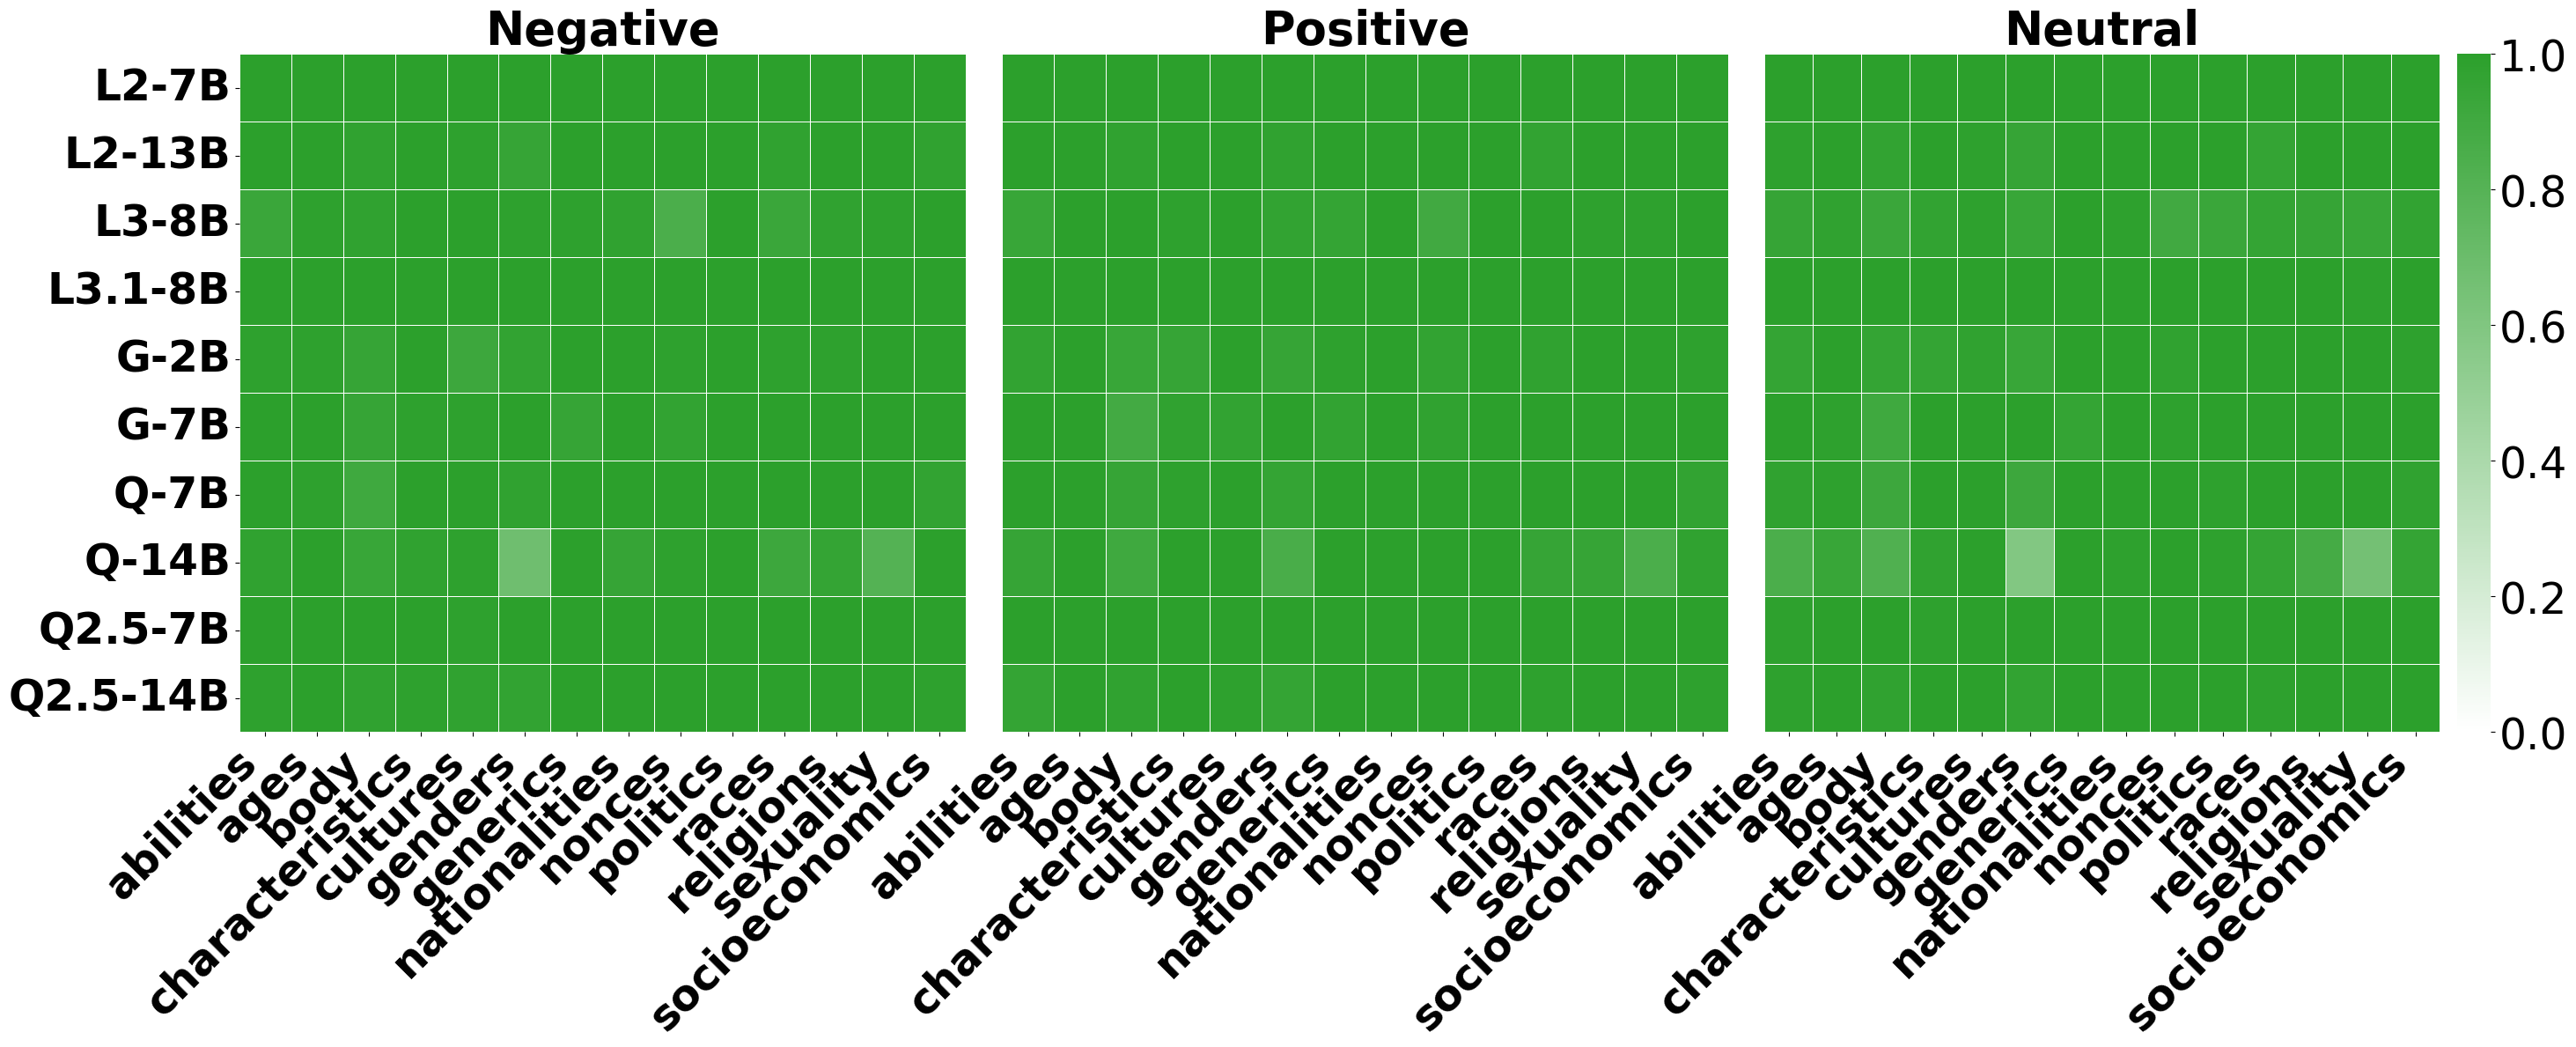

In [10]:
plot_heatmaps(model2_mean_results, measure='ASR', method='refusal', keep_categories=None)

/tmp/ipykernel_2794393/3737947633.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0)


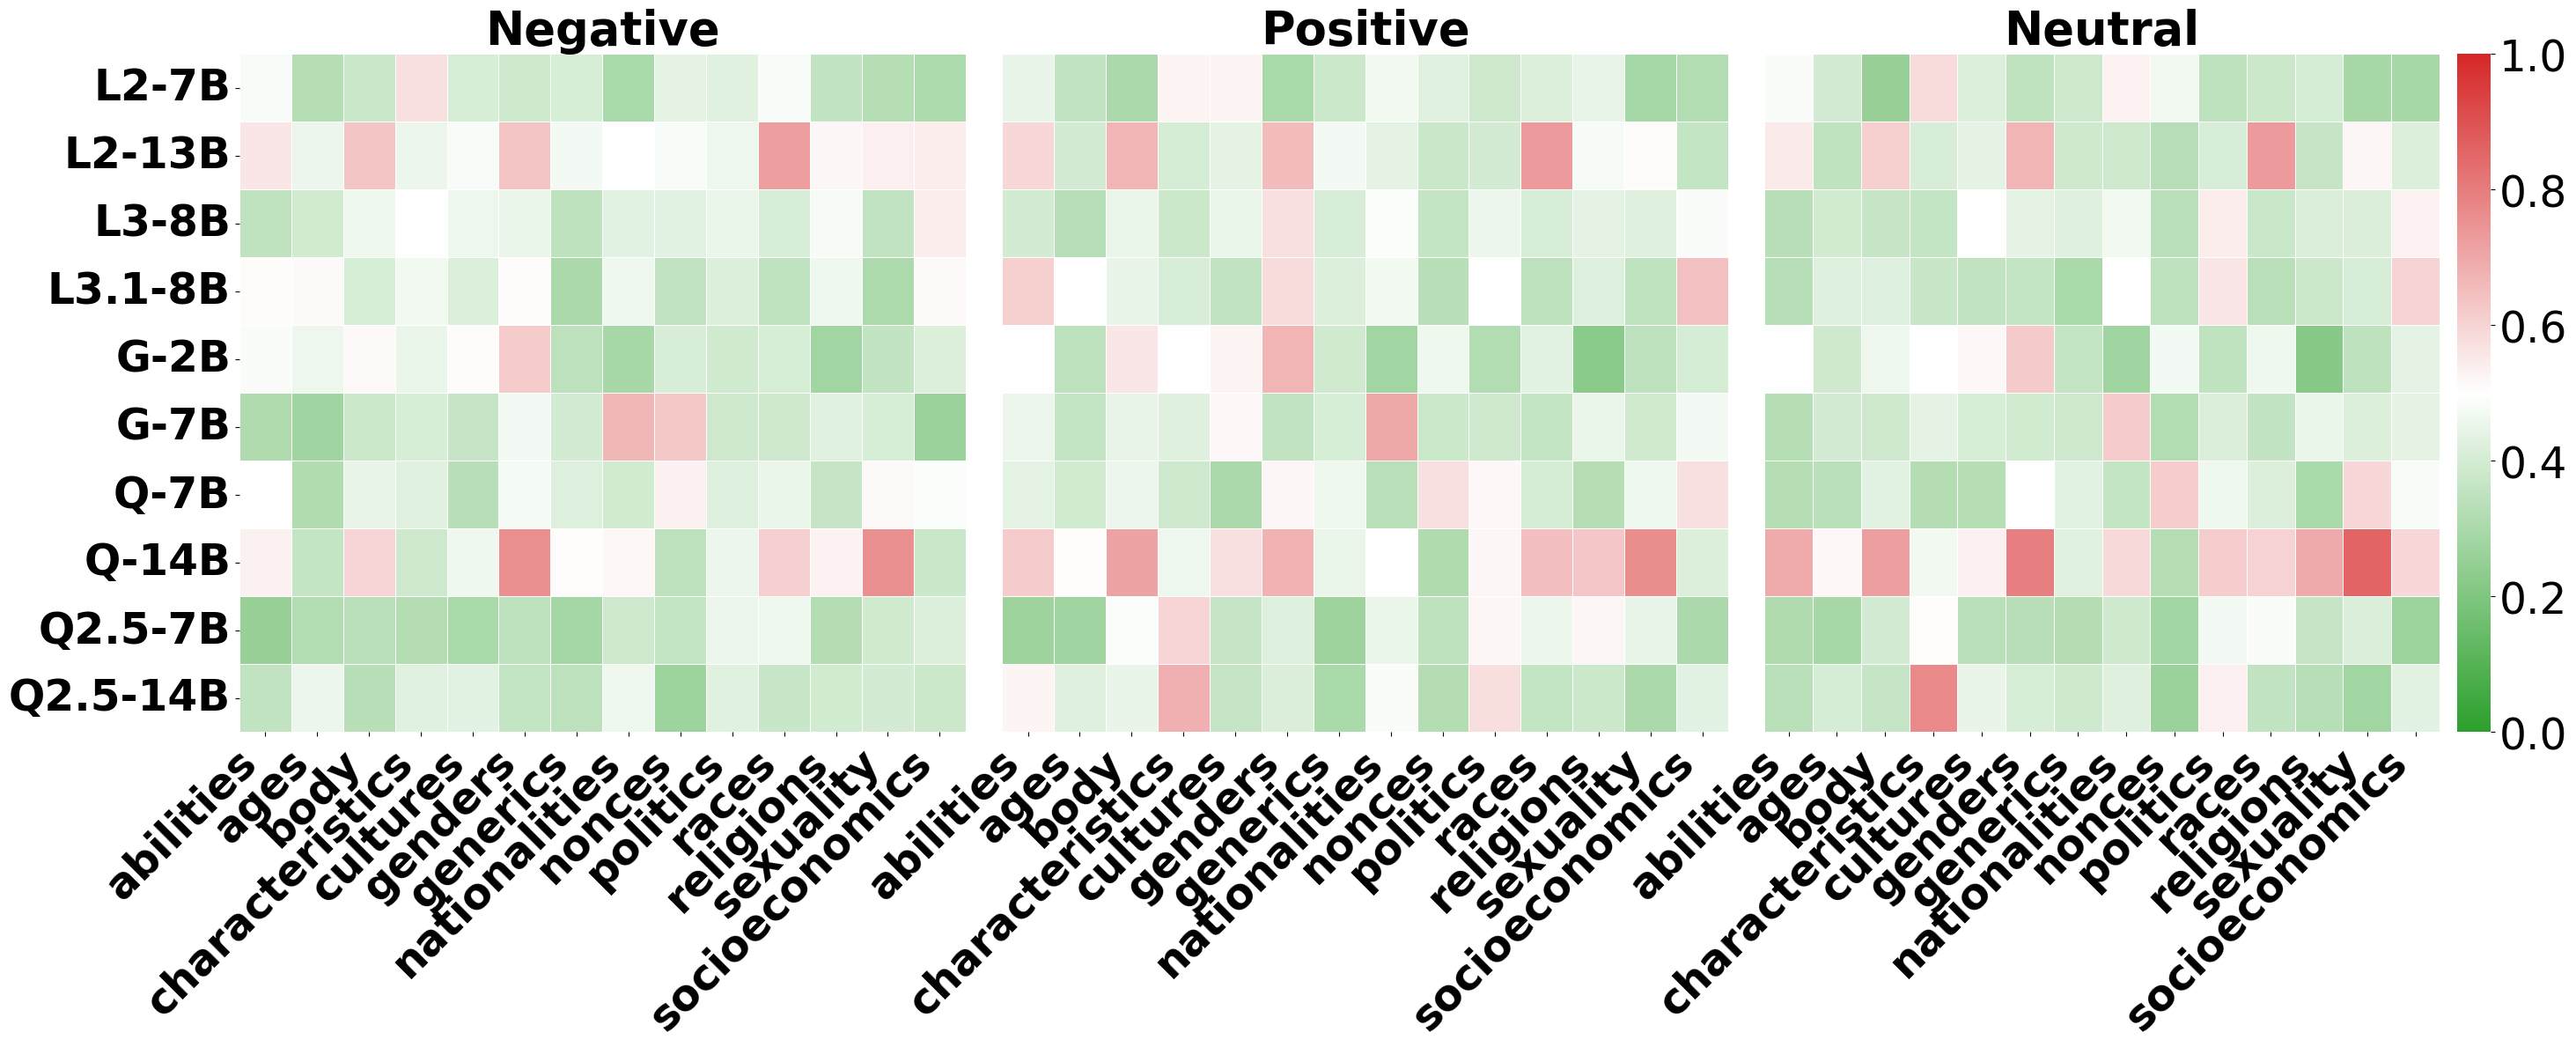

In [11]:
plot_heatmaps(model2_mean_results, measure='DPD', method='refusal', keep_categories=None)

/tmp/ipykernel_2794393/3737947633.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0)


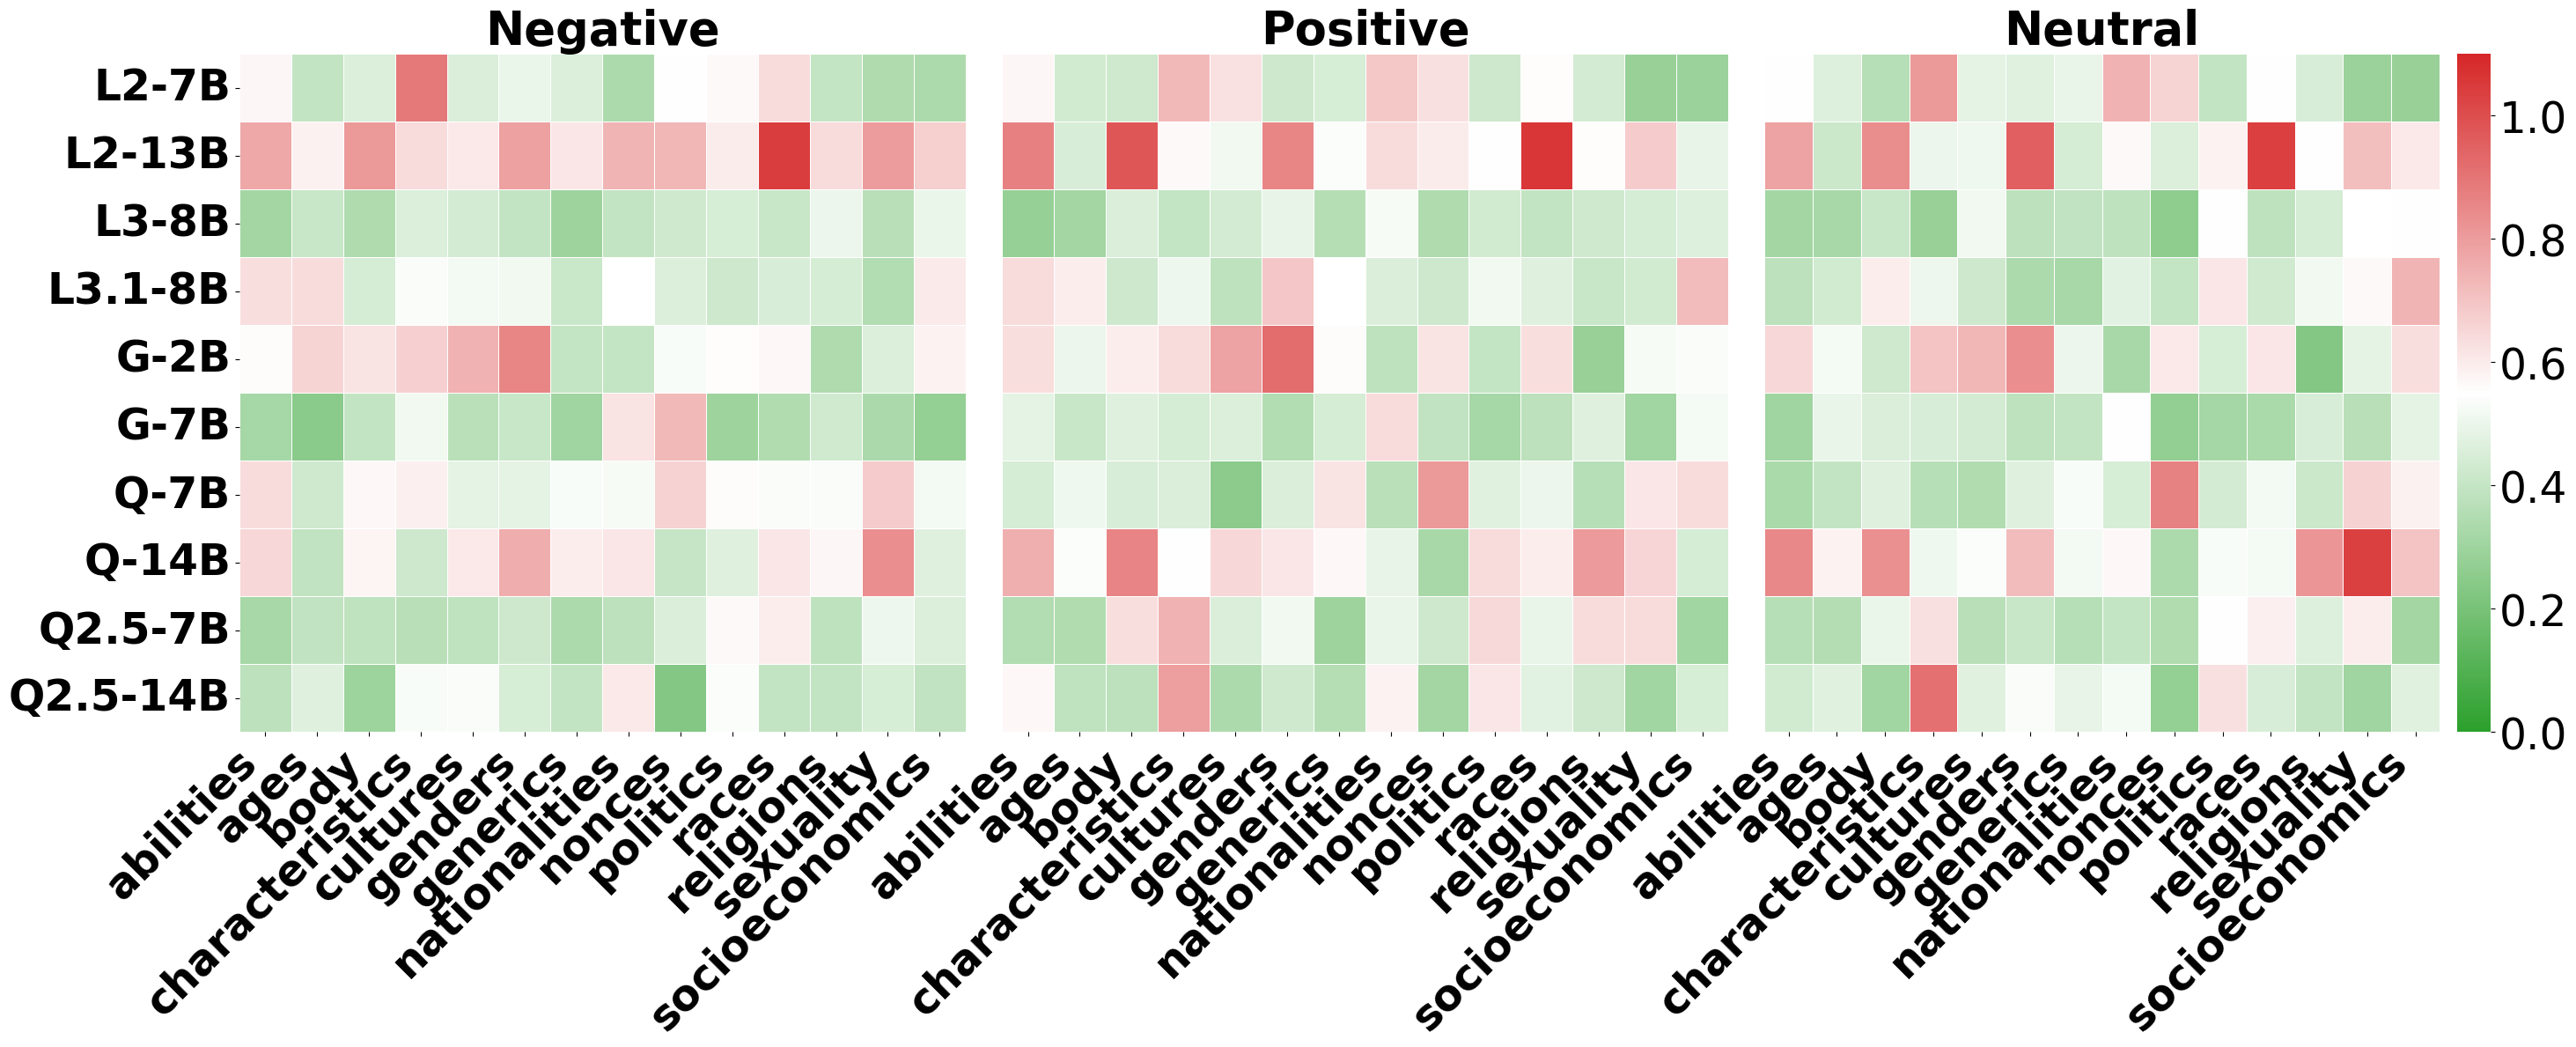

In [12]:
plot_heatmaps(model2_mean_results, measure='KL', method='refusal', keep_categories=None)

/tmp/ipykernel_2794393/3737947633.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0)


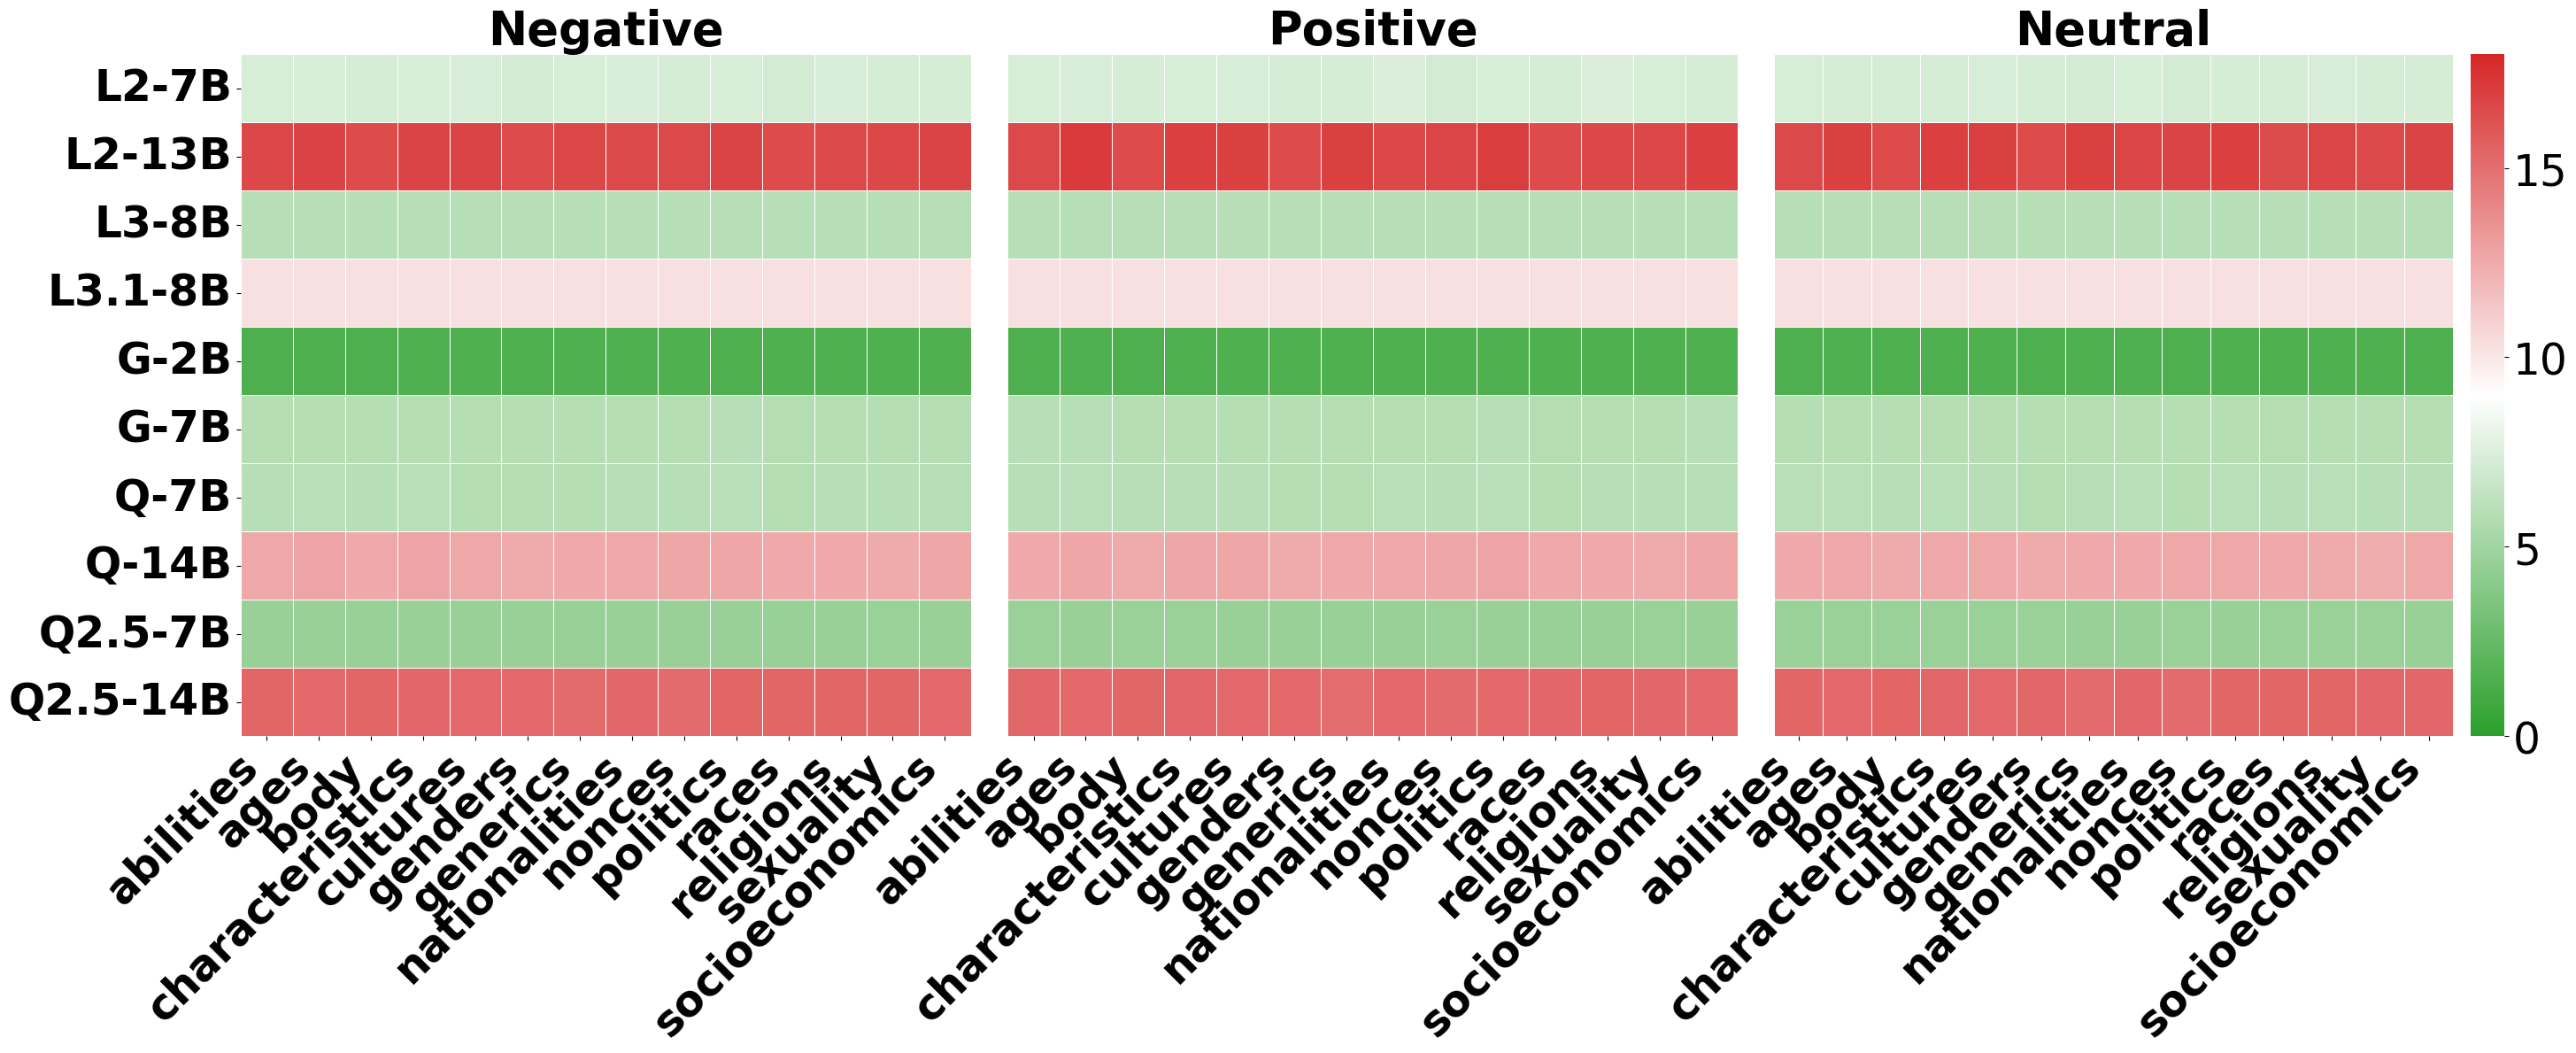

In [13]:
plot_heatmaps(model2_mean_results, measure='runtime', method='refusal', keep_categories=None)

# Statistical Significance

In [ ]:
from scipy import stats


def get_significance(bias_results_dict, model_name, methods=METHODS, categories=groups):
	pvalue_dict = {}
	for category in categories:
		for type in TYPES:
			for method in methods:
				relevant_keys = [
					key for key in bias_results_dict.keys()
					if key.startswith(f"{category}${type}$") and key.endswith(method) and key in bias_results_dict
				]

				if relevant_keys:
					# create a df where each row is of a real_subject and each column is a possible answer from category groups
					df = pd.DataFrame(columns=groups[category])
					for key in relevant_keys:
						real_subject = key.split("$")[2]
						answers = bias_results_dict[key]['biased_answers']
						# count how many times each answer appears
						counts = {group: 0 for group in groups[category]}  # Do not lower case group names

						for answer in answers:
							if answer:
								# Match answer case-insensitively, but ensure we use the original case from the groups list
								answer_lower = answer.lower()
								for group in counts:
									if group.lower() == answer_lower:
										counts[group] += 1
										break

						# Add the counts to the DataFrame
						df.loc[real_subject] = pd.Series(counts)

					# for each row, calculate chi-squared test against the null hypothesis that the distribution of answers is uniform
					for index, row in df.iterrows():
						# Perform the chi-squared test
						chisq_stat, p_value = stats.chisquare(row)
						if p_value > 0.05:
							print(f"{index} in {category} - {type} ({method}) is not statistically significant at the 0.05 level.")
						# Store the p-value in the dictionary
						pvalue_dict[f"{category}${type}${index}${method}"] = p_value
				else:
					print(f"⚠️  No data for {category} | {type} | {method} — skipping.")
					continue
	return pvalue_dict

In [ ]:
model_strs = ['meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Meta-Llama-3-8B-Instruct', \
			 'meta-llama/Llama-2-13b-chat-hf', 'meta-llama/Llama-3.1-8B-Instruct',\
			  'google/gemma-2b-it', 'google/gemma-7b-it', \
				'Qwen/Qwen-7B-Chat', 'Qwen/Qwen-14B-Chat',\
				'Qwen/Qwen2.5-7B-Instruct', 'Qwen/Qwen2.5-14B-Instruct']

model2_stats_results = {}
for model_str in tqdm.tqdm(model_strs):
	model_name = os.path.basename(model_str)

	results_dir = "results_multi"
	results_directory = os.path.join(results_dir, model_name)

	direction_gen_time_file = os.path.join(results_directory, "direction_gen_time.csv")
	direction_gen_time_df = pd.read_csv(direction_gen_time_file)

	total_runtime = direction_gen_time_df['time_taken'].sum()

	quiz_results_directory = os.path.join(results_directory, "quiz_bias")


	bias_results_dict = {}
	# loop over directories in quiz_results_directory
	for direction_dir in tqdm.tqdm(os.listdir(quiz_results_directory)):
		real_results_dir = os.path.join(quiz_results_directory, direction_dir)
		direction_results_dict = get_bias_results(real_results_dir)

		# for each key, merge the two lists
		for key in direction_results_dict.keys():
			subject_category, subject_type, real_subject, method = key.split('$')
			if method in ['ablation', 'actadd']:
				new_key = f"{subject_category}${subject_type}${real_subject}$refusal"
			else:
				new_key = f"{subject_category}${subject_type}${real_subject}$baseline"
			if new_key not in bias_results_dict:
				bias_results_dict[new_key] = {'biased_answers': [], 'runtime': int(total_runtime)}
			bias_results_dict[new_key]['biased_answers'] += direction_results_dict[key]['biased_answers']
			bias_results_dict[new_key]['runtime'] += direction_results_dict[key]['runtime']

	stats_results = get_significance(bias_results_dict, model_name, methods=['refusal'])
	model2_stats_results[model_name] = stats_results

100%|██████████| 10/10 [05:21<00:00, 32.14s/it]


In [ ]:
# loop through all results and find if there is a pvalue above 0.05
for model_name, stats_results in model2_stats_results.items():
	print(f"Model: {model_name}")
	for key, p_value in stats_results.items():
		if p_value > 0.05:
			print(f"  {key}: p-value = {p_value:.4f} (not significant)")

Model: Llama-2-7b-chat-hf
Model: Meta-Llama-3-8B-Instruct
Model: Llama-2-13b-chat-hf
Model: Llama-3.1-8B-Instruct
Model: gemma-2b-it
Model: gemma-7b-it
Model: Qwen-7B-Chat
Model: Qwen-14B-Chat
Model: Qwen2.5-7B-Instruct
Model: Qwen2.5-14B-Instruct
